In [2]:
!pip install torchvision
!pip install efficientnet_pytorch
from google.colab import drive
import torch
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
drive.mount('/content/drive')


  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp36-none-any.whl size=12422 sha256=a275a38e6011becbcfe9e2d021565f7f4db5eb0f60d36b2ba77700327515df37
  Stored in directory: /root/.cache/pip/wheels/42/1e/a9/2a578ba9ad04e776e80bf0f70d8a7f4c29ec0718b92d8f6ccd
Successfully built efficientnet-pytorch
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
#Preprocess the data
trainSet = datasets.CIFAR10("drive/My Drive/EE569-Reports/hw_5", train = True, download = True, 
            transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),transforms.RandomErasing()]))
testSet = datasets.CIFAR10("drive/My Drive/EE569-Reports/hw_5",  train = False, download = True, 
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
trainImages = torch.utils.data.DataLoader(trainSet, batch_size = 64, shuffle = True, num_workers=2)
testImages = torch.utils.data.DataLoader(testSet, batch_size = 1000, shuffle = True,num_workers=2)




Files already downloaded and verified
Files already downloaded and verified


In [0]:
#To check whether the data is balanced
count = 0
obj_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}
for imgs in trainImages:
  Images, labels = imgs
  for l in labels:
    obj_dict[int(l)] += 1
    count +=1
print (obj_dict)


In [13]:
#Model 7: Weight decay, Data augmentation, Data Processsing
#Build a Neural Network
import torch.nn as nn
import torch.nn.functional as Func
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        #model = EfficientNet.from_pretrained(model_name)
        #self.model = model

        #Defining 2 convolution layers
        self.convotionLayer1 = nn.Conv2d(3, 32, 3)
        self.drop1 = nn.Dropout2d(0.2)
        self.conv1_bn = nn.BatchNorm2d(32)

        self.convotionLayer2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(32)

        self.convotionLayer3 = nn.Conv2d(32, 64, 3)
        self.drop3 = nn.Dropout2d(0.3)
        self.conv3_bn = nn.BatchNorm2d(64)

        self.convotionLayer4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(64)

        self.convotionLayer5 = nn.Conv2d(64, 128, 3)
        self.drop5 = nn.Dropout2d(0.4)
        self.conv5_bn = nn.BatchNorm2d(128)

        #Defining Fully connected Layers (y = Wx + b)
        self.fullyConnected1 = nn.Linear(128*2*2, 256)
        self.fc1_bn = nn.BatchNorm1d(256)

        self.fullyConnected2 = nn.Linear(256, 64)
        self.fc2_bn = nn.BatchNorm1d(128)

        self.fullyConnected3 = nn.Linear(64, 10)

    def forward(self, imageFeatures):
        elu = nn.ELU()

        conv1 = elu(self.conv1_bn(self.drop1(self.convotionLayer1(imageFeatures))))
        imageFeatures = Func.max_pool2d(conv1, (2, 2))
        #print(imageFeatures.shape)
        # If the size is a square you can only specify a single number

        imageFeatures = elu(self.conv2_bn(self.convotionLayer2(imageFeatures)))
        #print(imageFeatures.shape)

        conv3 = elu(self.conv3_bn(self.drop3(self.convotionLayer3(imageFeatures))))
        imageFeatures = Func.max_pool2d(conv3, (2, 2))
        #print(imageFeatures.shape)

        imageFeatures = elu(self.conv4_bn(self.convotionLayer4(imageFeatures)))
        #print(imageFeatures.shape)


        conv5 = elu(self.conv5_bn(self.drop5(self.convotionLayer5(imageFeatures))))
        imageFeatures = Func.max_pool2d(conv5, (2, 2))

        #print(imageFeatures.shape)

        imageFeatures = imageFeatures.view(-1, 128*2*2)
        imageFeatures = elu(self.fc1_bn(self.fullyConnected1(imageFeatures)))
        imageFeatures = elu(self.fc2_bn(self.fullyConnected2(imageFeatures)))
        imageFeatures = self.fullyConnected3(imageFeatures)
        return imageFeatures

    def num_flat_features(self, imageFeatures):
      length = imageFeatures.size()[1:]  # all dimensions except the batch dimension
      featureDim = 1
      for k in length:
        featureDim *= k
      return featureDim

cnn = Net()
print(cnn)
params = list(cnn.parameters())
print(len(params))
#print(params[0].size())

input = torch.randn(3,3,32,32)
output = cnn(input)
print(output)
labels = torch.randn(10)
labels = labels.view(1, -1) 

numberOfParams= sum(p.numel() for p in cnn.parameters() if p.requires_grad)
print(numberOfParams)

Net(
  (convotionLayer1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (drop1): Dropout2d(p=0.2, inplace=False)
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convotionLayer2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convotionLayer3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop3): Dropout2d(p=0.3, inplace=False)
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convotionLayer4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convotionLayer5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (drop5): Dropout2d(p=0.4, inplace=False)
  (conv5_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fully

In [0]:
import torch.optim as optim

def evalAccuracy():
  #Overall train and test accuracy
  correctClassification_train = 0
  totalImages_train = 0

  correctClassification_test = 0
  totalImages_test = 0

  with torch.no_grad():
    for data in trainImages:
      img, label = data
      output = cnn(img)
      for i,k in enumerate(output):
        if torch.argmax(k) == label[i]:
          correctClassification_train +=1
        totalImages_train +=1

  with torch.no_grad():
    for data in testImages:
      img, label = data
      output = cnn(img)
      for i,k in enumerate(output):
        if torch.argmax(k) == label[i]:
          correctClassification_test +=1
        totalImages_test +=1

  trainAccuracy = correctClassification_train/totalImages_train      
  testAccuracy = correctClassification_test/totalImages_test
  return trainAccuracy, testAccuracy

def training(learningRate, momentum, epochs, criterion, optimizer):
  trainingAccuracyList = []
  testingAccuracyList = []

  running_loss = 0
  for epoch in range(epochs):
    print("Epochs: ",epoch)
    for i, trainData in enumerate(trainImages, 0):
      imgs, labels = trainData

      #set the gradient to zero
      optimizer.zero_grad()
      outputs = cnn(imgs)
      loss = criterion(outputs, labels)
      #loss.requires_grad = True
      loss.backward()
      optimizer.step()
      
    print(loss)

    #Saving the Model after each Epoch
    checkpoint = {'model': Net(),
          'state_dict': cnn.state_dict(),
          'optimizer' : optimizer.state_dict()}
    torch.save(checkpoint, 'drive/My Drive/EE569-Reports/569_competition/dropout_final_aste.pth')  
    
    trainAccuracy, testAccuracy = evalAccuracy()
    trainingAccuracyList.append(trainAccuracy)
    testingAccuracyList.append(testAccuracy)

  return trainingAccuracyList, testingAccuracyList

#define training parameters
learningRate = 0.001
momentum = 0.9
epochs = 80
criterion = nn.CrossEntropyLoss()
#optimizer= optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
optimizer= optim.Adam(cnn.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.0001, amsgrad=False)
#optimizer = optim.RMSprop(cnn.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0.0001, momentum=0.9, centered=False)

#Call training function
trainingAccuracyList, testingAccuracyList = training(learningRate, momentum, epochs, criterion, optimizer)
print("Train Accuracy for Each Epoch: ",trainingAccuracyList)
print("Test Accuracy for Each Epoch: ", testingAccuracyList)



Epochs:  0
tensor(1.5765, grad_fn=<NllLossBackward>)


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epochs:  1
tensor(1.6561, grad_fn=<NllLossBackward>)
Epochs:  2
tensor(1.0648, grad_fn=<NllLossBackward>)
Epochs:  3
tensor(1.0777, grad_fn=<NllLossBackward>)
Epochs:  4
tensor(1.0663, grad_fn=<NllLossBackward>)
Epochs:  5
tensor(0.9185, grad_fn=<NllLossBackward>)
Epochs:  6
tensor(1.1515, grad_fn=<NllLossBackward>)
Epochs:  7
tensor(1.1106, grad_fn=<NllLossBackward>)
Epochs:  8
tensor(1.2698, grad_fn=<NllLossBackward>)
Epochs:  9
tensor(1.6959, grad_fn=<NllLossBackward>)
Epochs:  10
tensor(1.2340, grad_fn=<NllLossBackward>)
Epochs:  11
tensor(1.4951, grad_fn=<NllLossBackward>)
Epochs:  12
tensor(1.1185, grad_fn=<NllLossBackward>)
Epochs:  13
tensor(1.4391, grad_fn=<NllLossBackward>)
Epochs:  14
tensor(1.1042, grad_fn=<NllLossBackward>)
Epochs:  15
tensor(1.2698, grad_fn=<NllLossBackward>)
Epochs:  16
tensor(0.8880, grad_fn=<NllLossBackward>)
Epochs:  17
tensor(1.0722, grad_fn=<NllLossBackward>)
Epochs:  18
tensor(1.5489, grad_fn=<NllLossBackward>)
Epochs:  19
tensor(1.0951, grad_fn=<N

In [7]:
numberOfParams= sum(p.numel() for p in cnn.parameters() if p.requires_grad)
print("Total Number of Parameters",numberOfParams)


0


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [8]:
#Overall train and test accuracy
correctClassification = 0
totalImages = 0

with torch.no_grad():
  for data in testImages:
    img, label = data
    output = cnn(img)
    for i,k in enumerate(output):
      if torch.argmax(k) == label[i]:
        correctClassification +=1
      totalImages +=1

print ("Accuracy: ", correctClassification/totalImages)

Accuracy:  0.8068


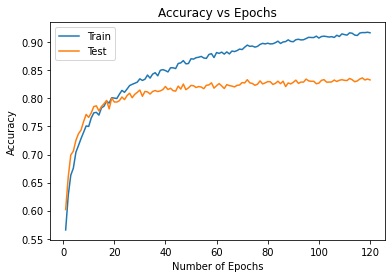

In [0]:
epochList = [i for i in range(1, 121)]
plt.plot(epochList, trainingAccuracyList, label = "Train")
plt.plot(epochList, testingAccuracyList, label = "Test")

plt.xlabel('Number of Epochs') 
plt.ylabel('Accuracy')  
plt.title('Accuracy vs Epochs') 
plt.legend()  
plt.show() 